In [57]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path


try:
    pd.set_option("mode.copy_on_write", True)
except Exception:
    pass

import matplotlib.pyplot as plt

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import joblib

In [58]:
# Paths
BASE_DIR = Path(r"C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\PdM")
print("[INFO] BASE_DIR =", BASE_DIR)

telemetry_path = BASE_DIR / "PdM_telemetry_small40.csv"
failures_path  = BASE_DIR / "PdM_failures.csv"
machines_path  = BASE_DIR / "PdM_machines.csv"
maint_path     = BASE_DIR / "PdM_maint.csv"
errors_path    = BASE_DIR / "PdM_errors.csv"

assert telemetry_path.exists(), f"Missing {telemetry_path}"
assert failures_path.exists(),  f"Missing {failures_path}"
assert machines_path.exists(),  f"Missing {machines_path}"
assert maint_path.exists(),     f"Missing {maint_path}"
assert errors_path.exists(),    f"Missing {errors_path}"

[INFO] BASE_DIR = C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\PdM


In [59]:
# Load & Clean

tele     = pd.read_csv(telemetry_path)
fails    = pd.read_csv(failures_path)
machines = pd.read_csv(machines_path)
maint    = pd.read_csv(maint_path)
errors   = pd.read_csv(errors_path)

tele["datetime"]  = pd.to_datetime(tele["datetime"], errors="coerce")
fails["datetime"] = pd.to_datetime(fails["datetime"], errors="coerce")
maint["datetime"] = pd.to_datetime(maint["datetime"], errors="coerce")
errors["datetime"] = pd.to_datetime(errors["datetime"], errors="coerce")

tele  = tele.sort_values(["machineID","datetime"]).drop_duplicates(["machineID","datetime"]).reset_index(drop=True)
fails = fails.sort_values(["machineID","datetime"]).drop_duplicates(["machineID","datetime"]).reset_index(drop=True)
maint = maint.sort_values(["machineID","datetime"]).drop_duplicates(["machineID","datetime"]).reset_index(drop=True)
errors = errors.sort_values(["machineID","datetime"]).drop_duplicates(["machineID","datetime"]).reset_index(drop=True)


for df in (tele, fails, machines, maint, errors):
    if "machineID" in df.columns:
        df["machineID"] = df["machineID"].astype(int)

print(f"[INFO] telemetry: {tele.shape} | failures: {fails.shape} | machines: {machines.shape} | maint: {maint.shape} | errors: {errors.shape}")

from IPython.display import display

display(tele.head(3))
display(fails.head(3))
display(machines.head(3))
display(maint.head(3))
display(errors.head(3))



[INFO] telemetry: (350440, 6) | failures: (281, 3) | machines: (40, 3) | maint: (1008, 3) | errors: (1431, 3)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5


In [60]:
# 24h Labeling
def make_labels_24h(tele_df: pd.DataFrame, fails_df: pd.DataFrame, horizon_h: float = 24.0) -> pd.DataFrame:
    parts = []
    for mid, g in tele_df.groupby("machineID", sort=True):
        g = g.sort_values("datetime").copy()
        f = (fails_df.loc[fails_df["machineID"] == mid, ["datetime"]]
                      .rename(columns={"datetime":"fail_time"})
                      .sort_values("fail_time"))
        if f.empty:
            g["label_next24h"] = 0
            parts.append(g)
            continue

        g = pd.merge_asof(g, f, left_on="datetime", right_on="fail_time", direction="forward")
        dt_h = (g["fail_time"] - g["datetime"]).dt.total_seconds() / 3600.0
        g["label_next24h"] = ((dt_h > 0) & (dt_h <= horizon_h)).astype(int)
        g.drop(columns=["fail_time"], inplace=True)
        parts.append(g)

    labeled = (pd.concat(parts, axis=0)
                 .sort_values(["machineID","datetime"])
                 .reset_index(drop=True))
    share = labeled["label_next24h"].value_counts(normalize=True).mul(100).round(2)
    print("[INFO] label distribution (%) →", dict(share))
    return labeled

tele_labeled = make_labels_24h(tele, fails)
display(tele_labeled.head(3))

tele_labeled["label_next24h"].value_counts()


[INFO] label distribution (%) → {0: 98.08, 1: 1.92}


,datetime,machineID,volt,rotate,pressure,vibration,label_next24h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0


label_next24h
0    343708
1      6732
Name: count, dtype: int64

In [61]:
# EDA / Tableau (Raw Sensor EDA)
tele_eda = tele_labeled.copy()

# Rename label for Tableau readability
tele_eda = tele_eda.rename(columns={"label_next24h": "label_true"})

# Keep only raw sensors + label (for EDA dashboard in Tableau)
eda_cols = [
    "datetime",
    "machineID",
    "volt", "rotate", "pressure", "vibration",
    "label_true"
]
tele_eda = tele_eda[eda_cols]

out_eda = r"C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\Tableau\telemetry_eda.csv"
tele_eda.to_csv(out_eda, index=False)

print("[OK] Saved telemetry_eda.csv for EDA / Tableau →", out_eda)

[OK] Saved telemetry_eda.csv for EDA / Tableau → C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\Tableau\telemetry_eda.csv


Records per machine (head):
machineID
1    8761
2    8761
3    8761
4    8761
5    8761
Name: count, dtype: int64


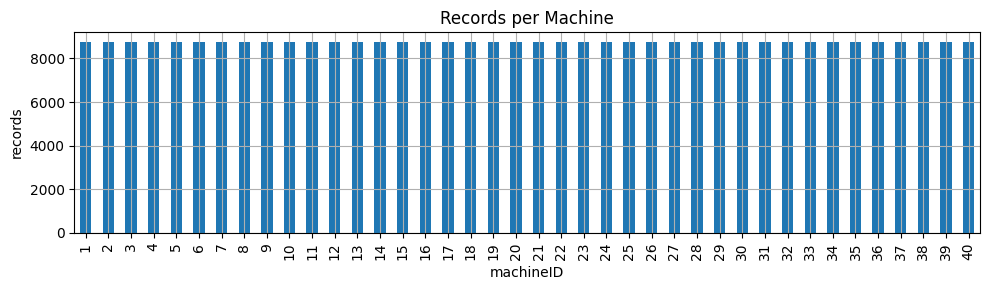


Failures per machine (head):
machineID
1    168
2     72
3    120
4    144
5    168
Name: label_next24h, dtype: int64


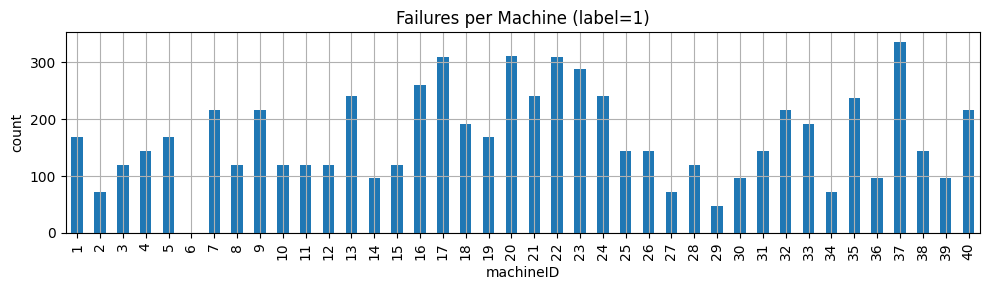


Label distribution (%)
label_next24h
0    98.08
1     1.92
Name: proportion, dtype: float64


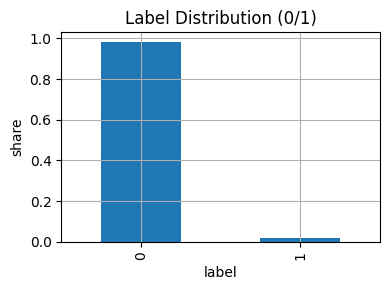

In [62]:
# EDA
def quick_eda(df: pd.DataFrame) -> None:
    rec_per_machine = df["machineID"].value_counts().sort_index()
    print("Records per machine (head):")
    print(rec_per_machine.head())
    plt.figure(figsize=(10,3))
    rec_per_machine.plot.bar(grid=True)
    plt.title("Records per Machine")
    plt.xlabel("machineID"); plt.ylabel("records")
    plt.tight_layout(); plt.show()

    fails_pm = df.groupby("machineID")["label_next24h"].sum().sort_index()
    print("\nFailures per machine (head):")
    print(fails_pm.head())
    plt.figure(figsize=(10,3))
    fails_pm.plot.bar(grid=True)
    plt.title("Failures per Machine (label=1)")
    plt.xlabel("machineID"); plt.ylabel("count")
    plt.tight_layout(); plt.show()

    lbl = df["label_next24h"].value_counts(normalize=True).mul(100).round(2)
    print("\nLabel distribution (%)")
    print(lbl)
    plt.figure(figsize=(4,3))
    df["label_next24h"].value_counts(normalize=True).plot.bar(grid=True)
    plt.title("Label Distribution (0/1)")
    plt.xlabel("label"); plt.ylabel("share")
    plt.tight_layout(); plt.show()

quick_eda(tele_labeled)

Overview
Shape: (350440, 7)
Columns: ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration', 'label_true']

Dtypes:
datetime      datetime64[ns]
machineID              int32
volt                 float64
rotate               float64
pressure             float64
vibration            float64
label_true             int64
dtype: object

Missing values:
datetime      0
machineID     0
volt          0
rotate        0
pressure      0
vibration     0
label_true    0
dtype: int64

Sensor stats:
              count        mean        std         min         25%  \
volt       350440.0  170.790302  15.527629   97.333604  160.312973   
rotate     350440.0  446.577797  52.669595  160.258190  412.151747   
pressure   350440.0  100.837425  11.037535   51.254043   93.491693   
vibration  350440.0   40.401819   5.384601   17.887288   36.780324   

                  50%         75%         max  
volt       170.588599  181.025217  255.124717  
rotate     447.524492  482.137028  695.020984  
pr

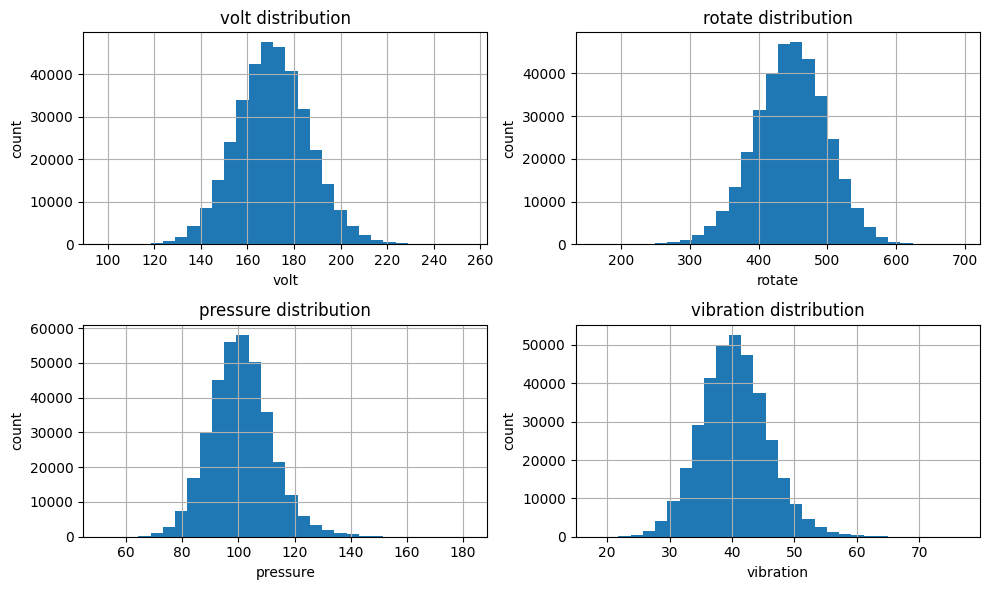

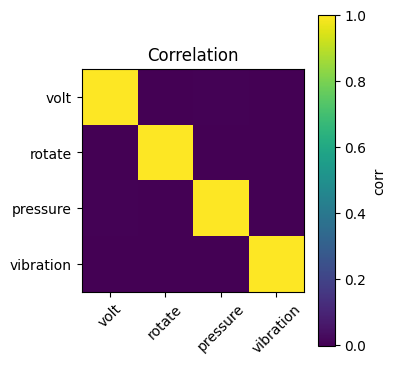

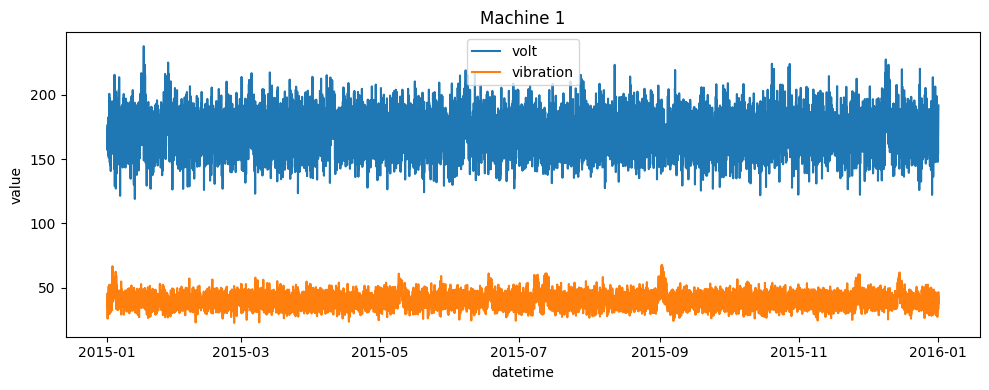

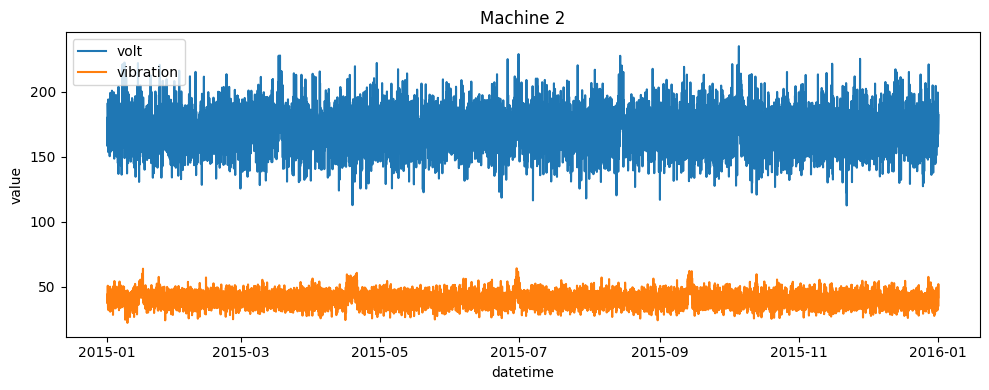

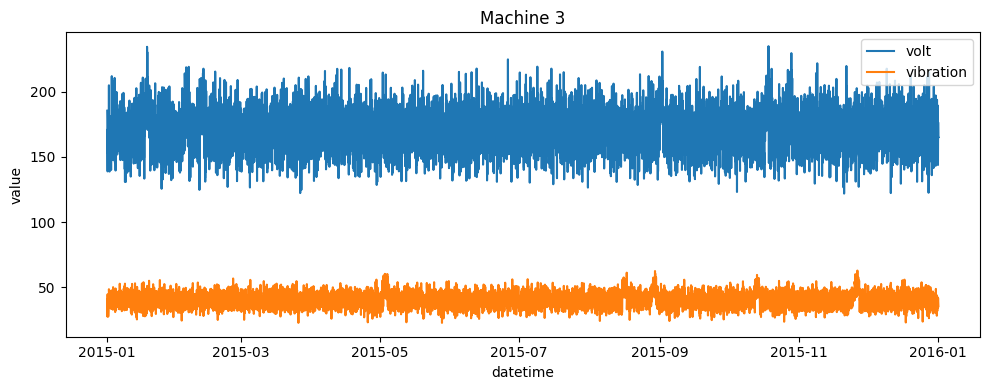

Extended EDA completed.


In [63]:
# Extended EDA

def extended_eda(df: pd.DataFrame) -> None:
    print("Overview")
    print(f"Shape: {df.shape}")
    print("Columns:", list(df.columns))
    print("\nDtypes:")
    print(df.dtypes)

    if not np.issubdtype(df["datetime"].dtype, np.datetime64):
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    
    sensor_cols = ["volt", "rotate", "pressure", "vibration"]

    print("\nMissing values:")
    print(df.isna().sum())

    print("\nSensor stats:")
    print(df[sensor_cols].describe().T)

    # Sensor histograms
    plt.figure(figsize=(10, 6))
    for i, c in enumerate(sensor_cols, 1):
        plt.subplot(2, 2, i)
        df[c].hist(bins=30)
        plt.title(f"{c} distribution")
        plt.xlabel(c)
        plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    corr = df[sensor_cols].corr()
    plt.figure(figsize=(4, 4))
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(sensor_cols)), sensor_cols, rotation=45)
    plt.yticks(range(len(sensor_cols)), sensor_cols)
    plt.colorbar(label="corr")
    plt.title("Correlation")
    plt.tight_layout()
    plt.show()

    # Time-series examples (volt + vibration)
    sample_machines = df["machineID"].unique()[:3]
    for mid in sample_machines:
        sub = df[df["machineID"] == mid].sort_values("datetime")
        if sub.empty:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(sub["datetime"], sub["volt"], label="volt")
        plt.plot(sub["datetime"], sub["vibration"], label="vibration")
        plt.title(f"Machine {mid}")
        plt.xlabel("datetime")
        plt.ylabel("value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("Extended EDA completed.")


# Run Extended EDA (after basic one)
extended_eda(tele_eda)


In [64]:
# Rolling + Maintenance + Error Features
ROLL_SENSORS = ["volt", "rotate", "pressure", "vibration"]
ROLL_WINDOWS = ["3H", "6H"]

def add_rolling_features(df: pd.DataFrame,
                         maint_df: pd.DataFrame,
                         errors_df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for mid, g in df.groupby("machineID", sort=True):
        g = g.sort_values("datetime").copy().set_index("datetime")

        # Rolling features for sensors
        for s in ROLL_SENSORS:
            if s not in g.columns:
                continue
            for win in ROLL_WINDOWS:
                g[f"{s}_mean_{win}"] = g[s].rolling(win, min_periods=2).mean()
                g[f"{s}_std_{win}"]  = g[s].rolling(win, min_periods=2).std()

        #Maintenance info
        m = maint_df.loc[maint_df["machineID"] == mid, ["datetime", "comp"]]
        if not m.empty:
            m = m.rename(columns={"datetime": "maint_time"})
            g = pd.merge_asof(g.reset_index(), m, left_on="datetime", right_on="maint_time",
                              by=None, direction="backward").drop(columns="maint_time")
            g.rename(columns={"comp": "last_maint_component"}, inplace=True)
        else:
            g["last_maint_component"] = np.nan

        #Error count in last 24h
        e = errors_df.loc[errors_df["machineID"] == mid, ["datetime", "errorID"]]
        if not e.empty:
            e = e.rename(columns={"datetime": "error_time"})
            g["error_count_24h"] = [
                ((e["error_time"] >= t - pd.Timedelta("24H")) & (e["error_time"] <= t)).sum()
                for t in g["datetime"]
            ]
        else:
            g["error_count_24h"] = 0

        out.append(g)

    feats = (pd.concat(out, axis=0)
             .sort_values(["machineID", "datetime"])
             .reset_index(drop=True))

    print("[INFO] features with rolling + maint + errors →", feats.shape)
    return feats

tele_feats = add_rolling_features(tele_labeled, maint, errors)
tele_feats.filter(regex="(volt|rotate|pressure|vibration)_(mean|std)|error_count_24h|last_maint_component").head(3)


[INFO] features with rolling + maint + errors → (350440, 25)


,volt_mean_3H,volt_std_3H,volt_mean_6H,volt_std_6H,rotate_mean_3H,rotate_std_3H,rotate_mean_6H,rotate_std_6H,pressure_mean_3H,pressure_std_3H,pressure_mean_6H,pressure_std_6H,vibration_mean_3H,vibration_std_3H,vibration_mean_6H,vibration_std_6H,last_maint_component,error_count_24h
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,comp1,0
1,169.548538,9.431836,169.548538,9.431836,410.625784,11.141591,410.625784,11.141591,104.269230,12.457390,104.269230,12.457390,44.250829,1.183494,44.250829,1.183494,comp1,0
2,170.028993,6.721032,170.028993,6.721032,449.533798,67.849599,449.533798,67.849599,94.592122,18.934956,94.592122,18.934956,40.893502,5.874970,40.893502,5.874970,comp1,0


In [65]:
# Join Machine Meta, Clean, and Build X/y (+Scaled)
df = tele_feats.merge(machines[["machineID","age","model"]], on="machineID", how="left")

df["last_maint_component"] = df["last_maint_component"].astype("object")
df["model"] = df["model"].astype("object")

y = df["label_next24h"].astype(int)
X = df.drop(columns=["datetime","label_next24h"]).copy()

non_num = X.select_dtypes(include=["object","category"]).columns.tolist()
if non_num:
    print("[INFO] One-hot encoding:", non_num)
    X = pd.get_dummies(X, columns=non_num, drop_first=True)

print("[INFO] Missing values before dropna:", X.isna().sum().sum())
na_mask = X.isna().any(axis=1)
if na_mask.any():
    X = X.loc[~na_mask].reset_index(drop=True)
    y = y.loc[~na_mask].reset_index(drop=True)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns)

print(f"[INFO] X_raw: {X.shape} | X_scaled: {X_scaled.shape} | y: {y.shape}")
X.head(3)


[INFO] One-hot encoding: ['last_maint_component', 'model']
[INFO] Missing values before dropna: 640
[INFO] X_raw: (350400, 29) | X_scaled: (350400, 29) | y: (350400,)


,machineID,volt,rotate,pressure,vibration,volt_mean_3H,volt_std_3H,volt_mean_6H,volt_std_6H,rotate_mean_3H,...,vibration_mean_6H,vibration_std_6H,error_count_24h,age,last_maint_component_comp2,last_maint_component_comp3,last_maint_component_comp4,model_model2,model_model3,model_model4
0,1,162.879223,402.747490,95.460525,43.413973,169.548538,9.431836,169.548538,9.431836,410.625784,...,44.250829,1.183494,0,18,False,False,False,False,True,False
1,1,170.989902,527.349825,75.237905,34.178847,170.028993,6.721032,170.028993,6.721032,449.533798,...,40.893502,5.874970,0,18,False,False,False,False,True,False
2,1,162.462833,346.149335,109.248561,41.122144,165.443986,4.807415,168.137453,6.665324,425.415550,...,40.950662,4.798255,0,18,False,False,False,False,True,False



[INFO] Classification Report:
              precision    recall  f1-score   support

           0      0.997     0.997     0.997     68735
           1      0.848     0.822     0.835      1345

    accuracy                          0.994     70080
   macro avg      0.922     0.909     0.916     70080
weighted avg      0.994     0.994     0.994     70080

[INFO] Confusion Matrix:
[[68537   198]
 [  240  1105]]
[INFO] ROC-AUC:  0.9982
[INFO] PR-AUC:   0.9031


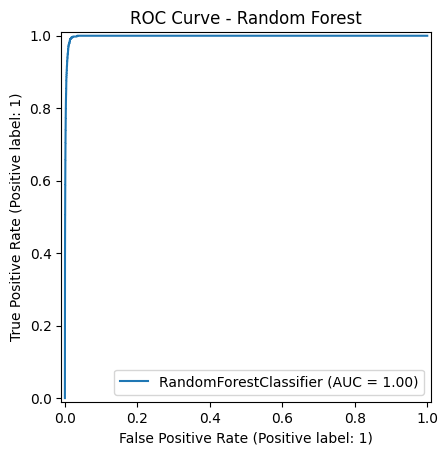

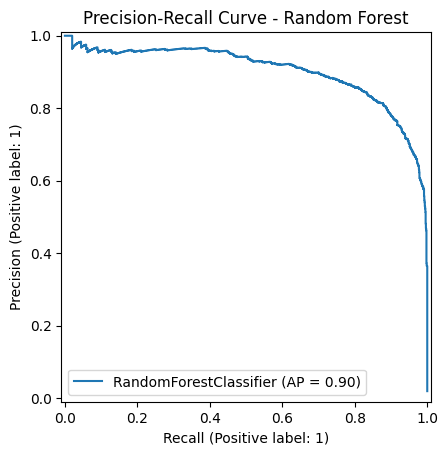


[INFO] Top 10 Important Features:


,feature,importance
0,error_count_24h,0.492691
1,rotate_mean_6H,0.079206
2,volt_mean_6H,0.070305
3,vibration_mean_6H,0.062539
4,rotate_mean_3H,0.052248
5,vibration_mean_3H,0.035115
6,pressure_mean_6H,0.033625
7,volt_mean_3H,0.032607
8,pressure_mean_3H,0.026932
9,vibration,0.014432


In [66]:
# Train/Test + Random Forest
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,                
    min_samples_split=4,          
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)


y_proba = rf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.50).astype(int)


print("\n[INFO] Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("[INFO] Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"[INFO] ROC-AUC:  {roc_auc_score(y_test, y_proba):.4f}")
print(f"[INFO] PR-AUC:   {average_precision_score(y_test, y_proba):.4f}")


RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test)
plt.title("Precision-Recall Curve - Random Forest")
plt.show()


imp = (
    pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)
print("\n[INFO] Top 10 Important Features:")
display(imp.head(10))


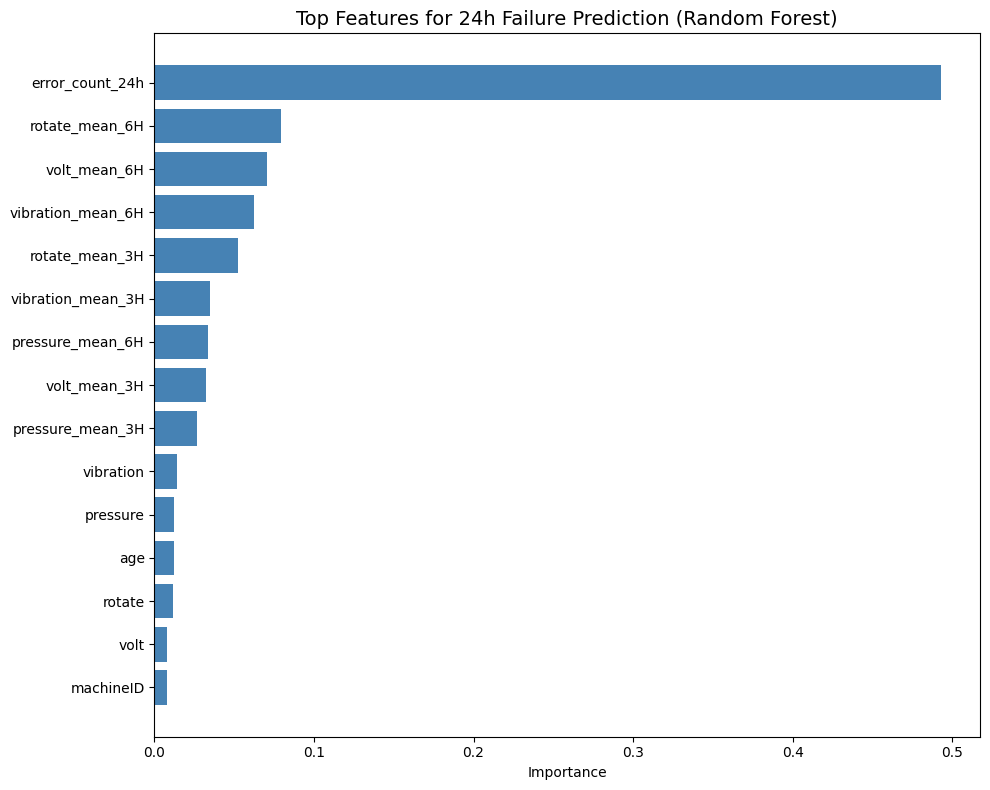

In [72]:
# Feature Importance Plot
plt.figure(figsize=(10, 8))
plt.barh(imp["feature"].head(15), imp["importance"].head(15), color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top Features for 24h Failure Prediction (Random Forest)", fontsize=14)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [67]:

# Create Tableau Dataset (Prediction Dataset)


print("\n[INFO] Building tableau_dataset.csv ...")

test_idx = y_test.index

df_tab = df.loc[test_idx, [
    "datetime",
    "machineID",
    "age",
    "model",
    "last_maint_component",
    "error_count_24h",
    "label_next24h"
]].copy()


df_tab = df_tab.rename(columns={"label_next24h": "label_true"})


df_tab["pred_proba"] = y_proba
df_tab["pred_label"] = y_pred


sensor_cols = [c for c in df.columns if any(
    x in c for x in ["volt_", "rotate_", "pressure_", "vibration_"]
)]
df_tab = df_tab.join(df.loc[test_idx, sensor_cols])


out_path = r"C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\Tableau\tableau_dataset.csv"
df_tab.to_csv(out_path, index=False)

print(f"[OK] Saved Tableau dataset → {out_path}")



[INFO] Building tableau_dataset.csv ...
[OK] Saved Tableau dataset → C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\Tableau\tableau_dataset.csv


In [68]:
# Threshold
import pandas as pd
from sklearn.metrics import classification_report

grid = [0.50, 0.40, 0.30, 0.20, 0.15, 0.10, 0.05]
beta = 2.0
rows = []

for thr in grid:
    pred_thr = (y_proba >= thr).astype(int)
    d = classification_report(y_test, pred_thr, output_dict=True, zero_division=0)
    p, r = d["1"]["precision"], d["1"]["recall"]
    f2 = (1 + beta**2) * p * r / (beta**2 * p + r) if (p + r) > 0 else 0.0
    rows.append([
        thr,
        p, r, f2,
        d["accuracy"],
        d["macro avg"]["f1-score"]
    ])

thr_df = (
    pd.DataFrame(rows,
                 columns=["threshold", "precision_1", "recall_1", "f2_1",
                          "accuracy", "macro_f1"])
      .sort_values("f2_1", ascending=False)
      .reset_index(drop=True)
)

# Round for better readability
thr_df[["precision_1","recall_1","f2_1","accuracy","macro_f1"]] = thr_df[
    ["precision_1","recall_1","f2_1","accuracy","macro_f1"]
].round(3)

print("[INFO] Threshold comparison (β=2, recall-weighted):")
display(thr_df)

# Best threshold hint
best_thr = thr_df.loc[0, "threshold"]
print(f"\n[INFO] Best threshold by F2 = {best_thr:.2f}")


[INFO] Threshold comparison (β=2, recall-weighted):


,threshold,precision_1,recall_1,f2_1,accuracy,macro_f1
0,0.20,0.710,0.946,0.887,0.992,0.904
1,0.15,0.677,0.961,0.887,0.990,0.895
2,0.10,0.638,0.977,0.883,0.989,0.883
3,0.30,0.751,0.921,0.881,0.993,0.912
4,0.40,0.798,0.888,0.869,0.994,0.919
5,0.05,0.555,0.992,0.857,0.985,0.852
6,0.50,0.848,0.822,0.827,0.994,0.916



[INFO] Best threshold by F2 = 0.20


In [69]:
# Finalize 

BEST_THR = float(thr_df.loc[0, "threshold"])
print(f"[INFO] Selected threshold by F2 → {BEST_THR:.2f}")


sample = X.sample(1, random_state=42)
prob   = rf.predict_proba(sample)[:, 1][0]
label  = int(prob >= BEST_THR)

print("\n=== Demo inference on one random sample ===")
display(sample.T)
print(f"Predicted probability: {prob:.3f}")
print(f"Predicted label @ thr={BEST_THR:.2f} → {label}")


if prob >= BEST_THR:
    print("⚠️  Maintenance ALERT — failure risk detected in next 24h.")
else:
    print("✅  Machine operating normally.")


[INFO] Selected threshold by F2 → 0.20

=== Demo inference on one random sample ===


,60763
machineID,7
volt,162.2362
rotate,515.026931
pressure,87.245593
vibration,44.404307
volt_mean_3H,164.904899
volt_std_3H,8.042432
volt_mean_6H,174.138289
volt_std_6H,13.25254
rotate_mean_3H,421.346803


Predicted probability: 0.136
Predicted label @ thr=0.20 → 0
✅  Machine operating normally.


In [70]:
#streamlit

import json, joblib

# Define the absolute path to your app folder
ART = Path(r"C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\predictive_maintenance_app\artifacts")
ART.mkdir(exist_ok=True)

# 1) Save model and scaler
joblib.dump(rf, ART / "model_rf.pkl")
joblib.dump(scaler, ART / "scaler.pkl")

# 2) Save feature columns
with open(ART / "feature_columns.json", "w", encoding="utf-8") as f:
    json.dump(X.columns.tolist(), f, ensure_ascii=False, indent=2)

# 3) Save threshold
with open(ART / "best_threshold.txt", "w") as f:
    f.write(str(BEST_THR))

print("[OK] Saved artifacts to predictive_maintenance_app folder")


[OK] Saved artifacts to predictive_maintenance_app folder


In [71]:
# Save 200 random samples from all machines
X.sample(200, random_state=42).to_csv(
    r"C:\Probook\E\AI\Projects\Data Science\Predictive Maintenance\predictive_maintenance_app\sample_features.csv",
    index=False
)
print("[OK] Wrote sample_features.csv to predictive_maintenance_app folder")


[OK] Wrote sample_features.csv to predictive_maintenance_app folder
